<a href="https://colab.research.google.com/github/aysekonus/ml_optimization_algorithms/blob/main/optimizationAlgorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import time

In [ ]:
# Helper function
def show_images(image, num_row=2, num_col=5):
    # plot images
    image_size = int(np.sqrt(image.shape[-1]))
    image = np.reshape(image, (image.shape[0], image_size, image_size))
    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
    for i in range(num_row*num_col):
        ax = axes[i//num_col, i%num_col]
        ax.imshow(image[i], cmap='gray', vmin=0, vmax=1)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
def one_hot(x, k, dtype=np.float32):
    """Create a one-hot encoding of x of size k."""
    return np.array(x[:, None] == np.arange(k), dtype)

**Dataset preparation**

In [ ]:
#Loading
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize data 

x_train= x_train / 255.0
x_test = x_test / 255.0
 
# One-hot encode labels
num_labels = 10
y_train=one_hot(y_train.astype('int32'),num_labels)
y_test=one_hot(y_test.astype('int32'),num_labels)


x_train = x_train.reshape(60000,28*28)
x_test = x_test.reshape(10000,28*28)


11501568/11490434 [==============================] - 0s 0us/step


Training data: (60000, 784) (60000, 10)
Test data: (10000, 784) (10000, 10)


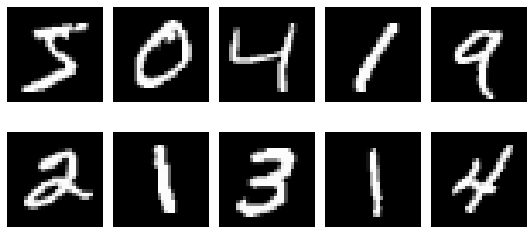

In [ ]:
print("Training data: {} {}".format(x_train.shape, y_train.shape))
print("Test data: {} {}".format(x_test.shape, y_test.shape))
show_images(x_train)

**Initialization**

In [ ]:
class DeepNeuralNetwork():
    def __init__(self, sizes, activation='sigmoid'):
        self.sizes = sizes
        
        # Choose activation function
        if activation == 'relu':
            self.activation = self.relu
        elif activation == 'sigmoid':
            self.activation = self.sigmoid
        else:
            raise ValueError("Activation function is currently not support, please use 'relu' or 'sigmoid' instead.")
        
        # Save all weights
        self.params = self.initialize()
        # Save all intermediate values, i.e. activations
        self.cache = {}
        
    def relu(self, x, derivative=False):
        if derivative:
            x = np.where(x < 0, 0, x)
            x = np.where(x >= 0, 1, x)
            return x
        return np.maximum(0, x)

    def sigmoid(self, x, derivative=False):
        if derivative:
            return (np.exp(-x))/((np.exp(-x)+1)**2)
        return 1/(1 + np.exp(-x))

    def softmax(self, x):
        # Numerically stable with large exponentials
        exps = np.exp(x - x.max())
        return exps / np.sum(exps, axis=0)

    def initialize(self):
        # number of nodes in each layer
        input_layer=self.sizes[0]
        hidden_layer=self.sizes[1]
        output_layer=self.sizes[2]
        
        params = {
            "W1": np.random.randn(hidden_layer, input_layer) * np.sqrt(1./input_layer),
            "b1": np.zeros((hidden_layer, 1)) * np.sqrt(1./input_layer),
            "W2": np.random.randn(output_layer, hidden_layer) * np.sqrt(1./hidden_layer),
            "b2": np.zeros((output_layer, 1)) * np.sqrt(1./hidden_layer)
        }
        return params
    
    def initialize_momemtum_optimizer(self):
        momemtum_opt = {
            "W1": np.zeros(self.params["W1"].shape),
            "b1": np.zeros(self.params["b1"].shape),
            "W2": np.zeros(self.params["W2"].shape),
            "b2": np.zeros(self.params["b2"].shape),
        }
        return momemtum_opt

    def initialize_rmsprop_optimizer(self):
        rmsprop_opt = {
            "W1": np.zeros(self.params["W1"].shape),
            "b1": np.zeros(self.params["b1"].shape),
            "W2": np.zeros(self.params["W2"].shape),
            "b2": np.zeros(self.params["b2"].shape),
        }
        return rmsprop_opt   

    def initialize_adam_optimizer(self):
        adam_opt_m = {
            "W1": np.zeros(self.params["W1"].shape),
            "b1": np.zeros(self.params["b1"].shape),
            "W2": np.zeros(self.params["W2"].shape),
            "b2": np.zeros(self.params["b2"].shape),
        }

        adam_opt_v = {
            "W1": np.zeros(self.params["W1"].shape),
            "b1": np.zeros(self.params["b1"].shape),
            "W2": np.zeros(self.params["W2"].shape),
            "b2": np.zeros(self.params["b2"].shape),
        }        

        return adam_opt_m, adam_opt_v

    def feed_forward(self, x):
        '''
            y = σ(wX + b)
        '''
        self.cache["X"] = x
        self.cache["Z1"] = np.matmul(self.params["W1"], self.cache["X"].T) + self.params["b1"]
        self.cache["A1"] = self.activation(self.cache["Z1"])
        self.cache["Z2"] = np.matmul(self.params["W2"], self.cache["A1"]) + self.params["b2"]
        self.cache["A2"] = self.softmax(self.cache["Z2"])
        return self.cache["A2"]
    
    def back_propagate(self, y, output):

        current_batch_size = y.shape[0]
        
        dZ2 = output - y.T
        dW2 = (1./current_batch_size) * np.matmul(dZ2, self.cache["A1"].T)
        db2 = (1./current_batch_size) * np.sum(dZ2, axis=1, keepdims=True)

        dA1 = np.matmul(self.params["W2"].T, dZ2)
        dZ1 = dA1 * self.activation(self.cache["Z1"], derivative=True)
        dW1 = (1./current_batch_size) * np.matmul(dZ1, self.cache["X"])
        db1 = (1./current_batch_size) * np.sum(dZ1, axis=1, keepdims=True)

        self.grads = {"W1": dW1, "b1": db1, "W2": dW2, "b2": db2}
        return self.grads
    
    def cross_entropy_loss(self, y, output):
        '''
            L(y, ŷ) = −∑ylog(ŷ).
        '''
        l_sum = np.sum(np.multiply(y.T, np.log(output)))
        m = y.shape[0]
        l = -(1./m) * l_sum
        return l
                
    def optimize(self, l_rate=0.1, beta=0.9, beta_2=0.999, epsilon=1e-6):
        '''
            Stochatic Gradient Descent (SGD):
              θ^(t+1) <- θ^t - η∇L(y, ŷ)
            
            Momentum:
              v^(t+1) <- βv^t + (1-β)∇L(y, ŷ)^t
              θ^(t+1) <- θ^t - ηv^(t+1)

            RmsProp:
              v(i+1) = β*v(i) + (1-β) * (∇L(y, ŷ))^2
              θ(i+1) = θ - (η/sqrt(v(i+1) + ϵ)) * ∇L(y, ŷ)

            Adam:
              m(i+1) = β*m(i) + (1-β) * ∇L(y, ŷ)
              v(i+1) = β2*v(i) + (1-β2) * (∇L(y, ŷ))^2 

              m_correct(i+1) = m(i+1) / (1 - β^(i+1))
              v_correct(i+1) = v(i+1) / (1 - β2^(i+1))

              θ(i+1) = θ(i) - (η/(sqrt(v_correct(i+1)) + ϵ) * m_correct(i+1))
        '''

        if self.optimizer == "sgd":
            for key in self.params:
                self.params[key] = self.params[key] - l_rate * self.grads[key]

        elif self.optimizer == "momentum":
            for key in self.params:
                self.momemtum_opt[key] = (beta * self.momemtum_opt[key] + (1. - beta) * self.grads[key])
                self.params[key] = self.params[key] - l_rate * self.momemtum_opt[key]

        elif self.optimizer == "rmsprop":
            for key in self.params:
                self.rmsprop_opt[key] = (beta * self.rmsprop_opt[key]) + (1. - beta) * pow(self.grads[key], 2)
                self.params[key] = self.params[key] - (l_rate / np.sqrt(self.rmsprop_opt[key] + epsilon)) * self.grads[key]

        elif self.optimizer == "adam":

            self.adam_opt_m_corrected = {}
            self.adam_opt_v_corrected = {}
            iter_count = 0  
            epsilon = 1e-8

            for key in self.params:
                iter_count = int(key[1])
                self.adam_opt_m[key] = (beta * self.adam_opt_m[key]) + (1. - beta) * self.grads[key]
                self.adam_opt_v[key] = (beta_2 * self.adam_opt_v[key]) + ((1. - beta_2) * pow(self.grads[key], 2))

                self.adam_opt_m_corrected[key] = self.adam_opt_m[key] / (1. - pow(beta, iter_count))
                self.adam_opt_v_corrected[key] = self.adam_opt_v[key] / (1. - pow(beta_2, iter_count))

                self.params[key] = self.params[key] - (l_rate / (np.sqrt(self.adam_opt_v_corrected[key]) + epsilon)) * self.adam_opt_m_corrected[key]
        else:
            raise ValueError("Optimizer is currently not support, please use 'sgd', 'momentum' or 'rmsprop' instead.")

    def accuracy(self, y, output):
        return np.mean(np.argmax(y, axis=-1) == np.argmax(output.T, axis=-1))

    def train(self, x_train, y_train, x_test, y_test, epochs=10, 
              batch_size=64, optimizer='momentum', l_rate=0.1, beta=.9, beta_2=0.999, epsilon=1e-6):
        # Hyperparameters
        self.epochs = epochs
        self.batch_size = batch_size
        num_batches = -(-x_train.shape[0] // self.batch_size)
        
        # Initialize optimizer
        self.optimizer = optimizer
        if self.optimizer == 'momentum':
            self.momemtum_opt = self.initialize_momemtum_optimizer()
        elif self.optimizer == 'rmsprop':
            self.rmsprop_opt = self.initialize_rmsprop_optimizer()        
        elif self.optimizer == 'adam':
            self.adam_opt_m, self.adam_opt_v = self.initialize_adam_optimizer()

        start_time = time.time()
        template = "Epoch {}: {:.2f}s, train acc={:.2f}, train loss={:.2f}, test acc={:.2f}, test loss={:.2f}"
        iter_count = 0
        # Train
        for i in range(self.epochs):
            # Shuffle
            permutation = np.random.permutation(x_train.shape[0])
            x_train_shuffled = x_train[permutation]
            y_train_shuffled = y_train[permutation]

            for j in range(num_batches):
                # Batch
                begin = j * self.batch_size
                end = min(begin + self.batch_size, x_train.shape[0]-1)
                x = x_train_shuffled[begin:end]
                y = y_train_shuffled[begin:end]
                
                # Forward
                output = self.feed_forward(x)
                # Backprop
                grad = self.back_propagate(y, output)
                # Optimize
                self.optimize(l_rate=l_rate, beta=beta, beta_2 = beta_2, epsilon=epsilon)

            # Evaluate performance
            # Training data
            output = self.feed_forward(x_train)
            train_acc = self.accuracy(y_train, output)
            train_loss = self.cross_entropy_loss(y_train, output)
            # Test data
            output = self.feed_forward(x_test)
            test_acc = self.accuracy(y_test, output)
            test_loss = self.cross_entropy_loss(y_test, output)
            print(template.format(i+1, time.time()-start_time, train_acc, train_loss, test_acc, test_loss))

## **1- Stokastik Gradient Descent Algoritması**

> **Relu fonksiyonu'nun eğitim süresinin sigmoid'e nazaran daha kısa olduğu, yani relu'nun daha hızlı çalıştığı gözlemlenmiştir.**

> **Ayrıca Relu aktivasyon fonksiyonu Sigmoid'e göre train ve test accuracy'leri kıyaslandığında daha başarılı bir eğitim gerçekleştirmiştir.**

**`10.Epoch için sonuç tablosu:`**
---

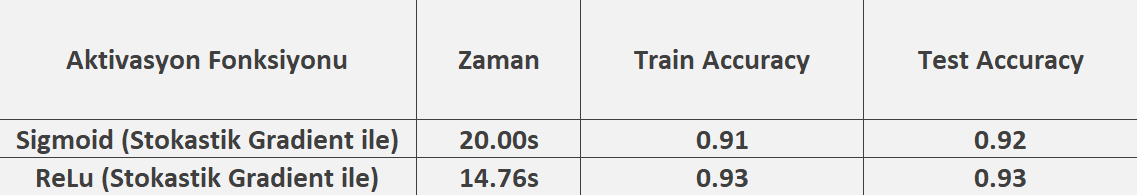




In [ ]:
# Sigmoid + sgd
dnn = DeepNeuralNetwork(sizes=[784, 64, 10], activation='sigmoid')
dnn.train(x_train, y_train, x_test, y_test, batch_size=128, optimizer='sgd', l_rate=0.05)

Epoch 1: 2.10s, train acc=0.82, train loss=0.96, test acc=0.82, test loss=0.94
Epoch 2: 4.13s, train acc=0.86, train loss=0.60, test acc=0.87, test loss=0.58
Epoch 3: 6.08s, train acc=0.88, train loss=0.48, test acc=0.89, test loss=0.46
Epoch 4: 8.21s, train acc=0.89, train loss=0.42, test acc=0.90, test loss=0.40
Epoch 5: 10.17s, train acc=0.90, train loss=0.38, test acc=0.90, test loss=0.37
Epoch 6: 12.16s, train acc=0.90, train loss=0.36, test acc=0.91, test loss=0.34
Epoch 7: 14.13s, train acc=0.91, train loss=0.34, test acc=0.91, test loss=0.33
Epoch 8: 16.07s, train acc=0.91, train loss=0.32, test acc=0.92, test loss=0.31
Epoch 9: 18.03s, train acc=0.91, train loss=0.31, test acc=0.92, test loss=0.30
Epoch 10: 20.00s, train acc=0.91, train loss=0.30, test acc=0.92, test loss=0.29


In [ ]:
# ReLU + SGD
dnn = DeepNeuralNetwork(sizes=[784, 64, 10], activation='relu')
dnn.train(x_train, y_train, x_test, y_test, batch_size=128, optimizer='sgd', l_rate=0.05)

Epoch 1: 1.49s, train acc=0.89, train loss=0.40, test acc=0.90, test loss=0.38
Epoch 2: 2.99s, train acc=0.90, train loss=0.33, test acc=0.91, test loss=0.32
Epoch 3: 4.46s, train acc=0.91, train loss=0.30, test acc=0.92, test loss=0.29
Epoch 4: 5.93s, train acc=0.92, train loss=0.29, test acc=0.92, test loss=0.28
Epoch 5: 7.40s, train acc=0.92, train loss=0.27, test acc=0.92, test loss=0.27
Epoch 6: 8.90s, train acc=0.92, train loss=0.27, test acc=0.92, test loss=0.26
Epoch 7: 10.34s, train acc=0.92, train loss=0.26, test acc=0.93, test loss=0.26
Epoch 8: 11.83s, train acc=0.93, train loss=0.25, test acc=0.93, test loss=0.25
Epoch 9: 13.29s, train acc=0.93, train loss=0.25, test acc=0.93, test loss=0.25
Epoch 10: 14.76s, train acc=0.93, train loss=0.25, test acc=0.93, test loss=0.25


## **2- Momentum Optimizasyon Algoritması**

> **Relu fonksiyonu'nun eğitim süresinin sigmoid'e nazaran daha kısa olduğu, yani relu'nun daha hızlı çalıştığı gözlemlenmiştir.**

> **Ayrıca Relu aktivasyon fonksiyonu Sigmoid'e göre train ve test accuracy'leri kıyaslandığında daha başarılı bir eğitim gerçekleştirmiştir.**

**`10.Epoch için sonuç tablosu:`**
---

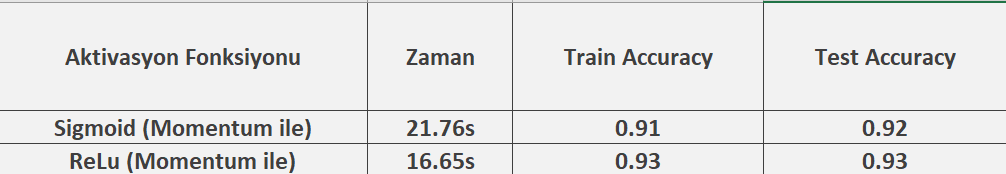

In [ ]:
# Sigmoid + Momentum
dnn = DeepNeuralNetwork(sizes=[784, 64, 10], activation='sigmoid')
dnn.train(x_train, y_train, x_test, y_test, batch_size=128, optimizer='momentum', l_rate=0.05, beta=0.9, epsilon=1e-6)

Epoch 1: 2.06s, train acc=0.81, train loss=1.01, test acc=0.82, test loss=0.99
Epoch 2: 4.20s, train acc=0.86, train loss=0.61, test acc=0.87, test loss=0.59
Epoch 3: 6.28s, train acc=0.88, train loss=0.48, test acc=0.89, test loss=0.46
Epoch 4: 8.40s, train acc=0.89, train loss=0.42, test acc=0.90, test loss=0.40
Epoch 5: 10.46s, train acc=0.90, train loss=0.38, test acc=0.90, test loss=0.37
Epoch 6: 12.59s, train acc=0.90, train loss=0.36, test acc=0.91, test loss=0.34
Epoch 7: 15.37s, train acc=0.91, train loss=0.34, test acc=0.91, test loss=0.33
Epoch 8: 17.51s, train acc=0.91, train loss=0.32, test acc=0.91, test loss=0.31
Epoch 9: 19.59s, train acc=0.91, train loss=0.31, test acc=0.92, test loss=0.30
Epoch 10: 21.76s, train acc=0.91, train loss=0.30, test acc=0.92, test loss=0.29


In [ ]:
# Relu + Momentum
dnn = DeepNeuralNetwork(sizes=[784, 64, 10], activation='relu')
dnn.train(x_train, y_train, x_test, y_test, batch_size=128, optimizer='momentum', l_rate=0.05, beta=0.9, epsilon=1e-6)

Epoch 1: 1.70s, train acc=0.89, train loss=0.40, test acc=0.89, test loss=0.38
Epoch 2: 3.38s, train acc=0.90, train loss=0.33, test acc=0.91, test loss=0.31
Epoch 3: 5.01s, train acc=0.91, train loss=0.30, test acc=0.92, test loss=0.29
Epoch 4: 6.69s, train acc=0.92, train loss=0.29, test acc=0.92, test loss=0.28
Epoch 5: 8.34s, train acc=0.92, train loss=0.28, test acc=0.92, test loss=0.27
Epoch 6: 9.99s, train acc=0.92, train loss=0.27, test acc=0.92, test loss=0.26
Epoch 7: 11.65s, train acc=0.92, train loss=0.26, test acc=0.92, test loss=0.26
Epoch 8: 13.35s, train acc=0.93, train loss=0.26, test acc=0.92, test loss=0.25
Epoch 9: 14.96s, train acc=0.93, train loss=0.25, test acc=0.93, test loss=0.25
Epoch 10: 16.65s, train acc=0.93, train loss=0.25, test acc=0.93, test loss=0.25


## **3- RMSProp Optimizasyon Algoritması**

> **Relu fonksiyonu'nun eğitim süresinin sigmoid'e nazaran daha kısa olduğu, yani relu'nun daha hızlı çalıştığı gözlemlenmiştir.**

> **Ayrıca Sigmoid aktivasyon fonksiyonu relu'ya göre train ve test accuracy'leri kıyaslandığında learning rate = 0.001 ve 10 epoch'luk bir eğitim için daha başarılı bir eğitim gerçekleştirmiştir.**

**`10.Epoch için sonuç tablosu:`**
---

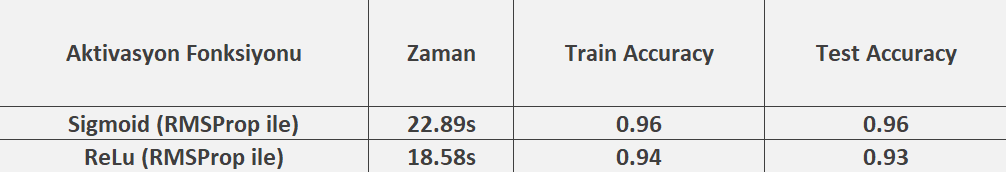

In [ ]:
# Sigmoid + RmsProp
dnn = DeepNeuralNetwork(sizes=[784, 64, 10], activation='sigmoid')
dnn.train(x_train, y_train, x_test, y_test, batch_size=128, optimizer='rmsprop', l_rate=0.001, beta=0.9, epsilon=1e-6)

Epoch 1: 2.30s, train acc=0.90, train loss=0.38, test acc=0.91, test loss=0.37
Epoch 2: 4.62s, train acc=0.92, train loss=0.28, test acc=0.92, test loss=0.27
Epoch 3: 6.89s, train acc=0.93, train loss=0.24, test acc=0.93, test loss=0.24
Epoch 4: 9.19s, train acc=0.94, train loss=0.21, test acc=0.94, test loss=0.21
Epoch 5: 11.48s, train acc=0.95, train loss=0.19, test acc=0.94, test loss=0.19
Epoch 6: 13.76s, train acc=0.95, train loss=0.17, test acc=0.95, test loss=0.18
Epoch 7: 16.04s, train acc=0.95, train loss=0.16, test acc=0.95, test loss=0.17
Epoch 8: 18.32s, train acc=0.96, train loss=0.15, test acc=0.95, test loss=0.15
Epoch 9: 20.62s, train acc=0.96, train loss=0.14, test acc=0.96, test loss=0.14
Epoch 10: 22.89s, train acc=0.96, train loss=0.13, test acc=0.96, test loss=0.14


In [ ]:
# Relu + RmsProp
dnn = DeepNeuralNetwork(sizes=[784, 64, 10], activation='relu')
dnn.train(x_train, y_train, x_test, y_test, batch_size=128, optimizer='rmsprop', l_rate=0.001, beta=0.9, epsilon=1e-6)

Epoch 1: 1.85s, train acc=0.91, train loss=0.30, test acc=0.92, test loss=0.29
Epoch 2: 3.69s, train acc=0.92, train loss=0.26, test acc=0.92, test loss=0.26
Epoch 3: 5.47s, train acc=0.93, train loss=0.25, test acc=0.93, test loss=0.25
Epoch 4: 7.32s, train acc=0.93, train loss=0.24, test acc=0.93, test loss=0.24
Epoch 5: 9.13s, train acc=0.93, train loss=0.23, test acc=0.93, test loss=0.23
Epoch 6: 10.93s, train acc=0.93, train loss=0.23, test acc=0.93, test loss=0.23
Epoch 7: 12.70s, train acc=0.94, train loss=0.22, test acc=0.93, test loss=0.23
Epoch 8: 14.51s, train acc=0.94, train loss=0.21, test acc=0.94, test loss=0.22
Epoch 9: 16.27s, train acc=0.94, train loss=0.22, test acc=0.93, test loss=0.23
Epoch 10: 18.58s, train acc=0.94, train loss=0.22, test acc=0.93, test loss=0.23


### NOT: 

**`Relu + RmsProp` learning rate 0.5 için denendiğinde eğitim sağlıklı gerçekleşmemiştir. Learning rate küçültülerek 0.001 için optimal bir eğitim gerçekleşebildiği gözlemlenmiştir.**

## **4- ADAM Optimizasyon Algoritması**

> **Relu fonksiyonu'nun eğitim süresinin sigmoid'e nazaran daha kısa olduğu, yani relu'nun daha hızlı çalıştığı gözlemlenmiştir.**

> **Ayrıca Sigmoid aktivasyon fonksiyonu relu'ya göre train ve test accuracy'leri kıyaslandığında learning rate = 0.05 ve 10 epoch'luk bir eğitim için daha başarılı bir eğitim gerçekleştirmiştir.**

**`10.Epoch için sonuç tablosu:`**
---
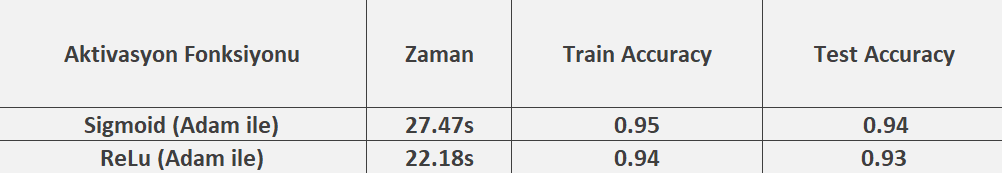

In [ ]:
# Sigmoid + Adam
dnn = DeepNeuralNetwork(sizes=[784, 64, 10], activation='sigmoid')
dnn.train(x_train, y_train, x_test, y_test, batch_size=128, optimizer='adam', l_rate=0.05, beta=0.9, beta_2=0.999, epsilon=1e-8)

Epoch 1: 2.59s, train acc=0.90, train loss=0.44, test acc=0.90, test loss=0.43
Epoch 2: 5.28s, train acc=0.91, train loss=0.34, test acc=0.92, test loss=0.33
Epoch 3: 7.88s, train acc=0.92, train loss=0.30, test acc=0.92, test loss=0.29
Epoch 4: 10.51s, train acc=0.93, train loss=0.27, test acc=0.93, test loss=0.27
Epoch 5: 13.11s, train acc=0.93, train loss=0.25, test acc=0.93, test loss=0.25
Epoch 6: 15.76s, train acc=0.93, train loss=0.24, test acc=0.93, test loss=0.24
Epoch 7: 18.35s, train acc=0.94, train loss=0.22, test acc=0.94, test loss=0.23
Epoch 8: 20.96s, train acc=0.94, train loss=0.21, test acc=0.94, test loss=0.22
Epoch 9: 24.29s, train acc=0.94, train loss=0.20, test acc=0.94, test loss=0.21
Epoch 10: 27.47s, train acc=0.95, train loss=0.19, test acc=0.94, test loss=0.20


In [ ]:
# Relu + Adam
dnn = DeepNeuralNetwork(sizes=[784, 64, 10], activation='relu')
dnn.train(x_train, y_train, x_test, y_test, batch_size=128, optimizer='adam', l_rate=0.05, beta=0.9, beta_2=0.999, epsilon=1e-8)

Epoch 1: 2.61s, train acc=0.91, train loss=0.31, test acc=0.92, test loss=0.30
Epoch 2: 5.30s, train acc=0.92, train loss=0.28, test acc=0.92, test loss=0.27
Epoch 3: 7.37s, train acc=0.92, train loss=0.26, test acc=0.93, test loss=0.26
Epoch 4: 9.52s, train acc=0.93, train loss=0.25, test acc=0.93, test loss=0.25
Epoch 5: 11.62s, train acc=0.93, train loss=0.24, test acc=0.93, test loss=0.24
Epoch 6: 13.69s, train acc=0.93, train loss=0.24, test acc=0.93, test loss=0.24
Epoch 7: 15.74s, train acc=0.93, train loss=0.23, test acc=0.93, test loss=0.24
Epoch 8: 17.84s, train acc=0.93, train loss=0.23, test acc=0.93, test loss=0.23
Epoch 9: 20.01s, train acc=0.93, train loss=0.23, test acc=0.93, test loss=0.23
Epoch 10: 22.18s, train acc=0.94, train loss=0.22, test acc=0.93, test loss=0.23


In [ ]:
# Relu + Adam (l_Rate = 0.001)
dnn = DeepNeuralNetwork(sizes=[784, 64, 10], activation='relu')
dnn.train(x_train, y_train, x_test, y_test, batch_size=128, optimizer='adam', l_rate=0.001, beta=0.9, beta_2=0.999, epsilon=1e-8)

Epoch 1: 2.58s, train acc=0.91, train loss=0.31, test acc=0.91, test loss=0.30
Epoch 2: 4.64s, train acc=0.92, train loss=0.28, test acc=0.92, test loss=0.27
Epoch 3: 6.71s, train acc=0.92, train loss=0.26, test acc=0.93, test loss=0.26
Epoch 4: 8.81s, train acc=0.93, train loss=0.25, test acc=0.93, test loss=0.25
Epoch 5: 10.86s, train acc=0.93, train loss=0.24, test acc=0.93, test loss=0.25
Epoch 6: 12.88s, train acc=0.93, train loss=0.24, test acc=0.93, test loss=0.24
Epoch 7: 14.92s, train acc=0.93, train loss=0.23, test acc=0.93, test loss=0.24
Epoch 8: 17.00s, train acc=0.93, train loss=0.23, test acc=0.93, test loss=0.24
Epoch 9: 19.11s, train acc=0.94, train loss=0.22, test acc=0.93, test loss=0.23
Epoch 10: 21.17s, train acc=0.94, train loss=0.22, test acc=0.93, test loss=0.23


In [ ]:
# Sigmoid + Adam (l_Rate = 0.001)
dnn = DeepNeuralNetwork(sizes=[784, 64, 10], activation='sigmoid')
dnn.train(x_train, y_train, x_test, y_test, batch_size=128, optimizer='adam', l_rate=0.001, beta=0.9, beta_2=0.999, epsilon=1e-8)

Epoch 1: 2.63s, train acc=0.90, train loss=0.44, test acc=0.90, test loss=0.43
Epoch 2: 5.23s, train acc=0.91, train loss=0.34, test acc=0.92, test loss=0.33
Epoch 3: 7.72s, train acc=0.92, train loss=0.30, test acc=0.92, test loss=0.29
Epoch 4: 10.59s, train acc=0.92, train loss=0.27, test acc=0.92, test loss=0.27
Epoch 5: 13.16s, train acc=0.93, train loss=0.25, test acc=0.93, test loss=0.25
Epoch 6: 16.86s, train acc=0.93, train loss=0.24, test acc=0.93, test loss=0.24
Epoch 7: 20.55s, train acc=0.94, train loss=0.22, test acc=0.93, test loss=0.23
Epoch 8: 23.07s, train acc=0.94, train loss=0.21, test acc=0.94, test loss=0.21
Epoch 9: 25.60s, train acc=0.94, train loss=0.20, test acc=0.94, test loss=0.21
Epoch 10: 28.24s, train acc=0.95, train loss=0.19, test acc=0.94, test loss=0.20


**Kod kaynak:** https://github.com/lionelmessi6410/Neural-Networks-from-Scratch/blob/main/NN-from-Scratch.ipynb

# **OPTIMIZASYON YONTEMLERININ KIYASLANMASI**

## **1- Sigmoid ile 4 Yöntemin Kıyaslanması**

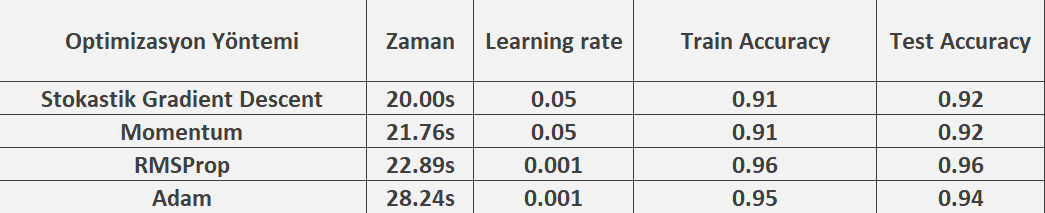

> **Test Accuracy için Sigmoid ile en hızlı yöntem Stokastik Gradient Descent algoritması iken, accuracy olarak doğruluğu en yüksek algoritma RMSProp olarak gözlemlenmiştir.**

## **2- Relu ile 4 Yöntemin Kıyaslanması**

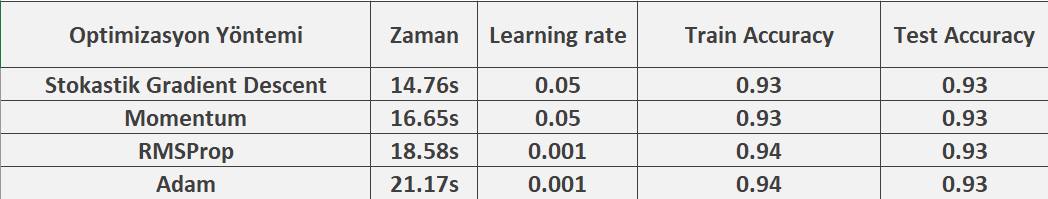

> **Test Accuracy için Sigmoid ile en hızlı yöntem Stokastik Gradient Descent algoritması iken, accuracy olarak doğruluğu en yüksek algoritma RMSProp ile Adam eşit olarak gözlemlenmiştir. Fakat ikisi arasında hız farkına bakıldığında RMSProp'un daha hızlı olduğu ve tercih sebebi olabileceği gözlemlenmiştir.**

# **SONUÇ**

> ***En yüksek accuracy sigmoid ile çalışan RMSProp algoritması ile elde edilmiştir.***